In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

## Przygotowanie danych

In [8]:
data = pd.read_csv("clustering.csv",header=None)
data.head()

,0,1
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


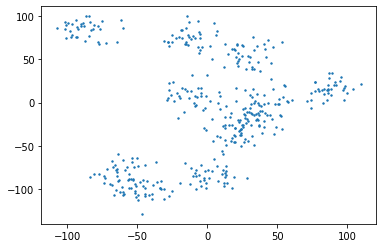

In [15]:
plt.scatter(data[0], data[1], s=2)
plt.show()

Analizowane dane są zbiorem punktów w dwuwymiarowej przestrzeni, bez żadnych dodatkowych informacji. Wykres sugerowałby wykorzystanie około 8 klastrów dla tego zbioru, jednak należy dokładniej sprawdzić zasadność takiego wyboru.

## KMeans + metoda łokcia

In [136]:
# Helper functions to display a grid of plots
plotGrid_length = 0
plotGrid_height = 0
plotGrid_count = 0
def initPlotGrid(rowLength, totalPlots, showTicks = False):
    global plotGrid_length, plotGrid_count, plotGrid_height
    plotGrid_length = rowLength
    plotGrid_height = (totalPlots // rowLength) + 1 if totalPlots % rowLength > 0 else totalPlots // rowLength
    plotGrid_count = 0
    
    plt.rcParams['figure.figsize'] = [30, 30/plotGrid_length*plotGrid_height*0.8]
    if(not showTicks):
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
    
def addToGrid():
    global plotGrid_length, plotGrid_count
    plt.subplot(plotGrid_height, plotGrid_length, plotGrid_count+1)
    plotGrid_count += 1
    
def finalizePlotGrid():
    plt.show()
    plt.style.use('default')

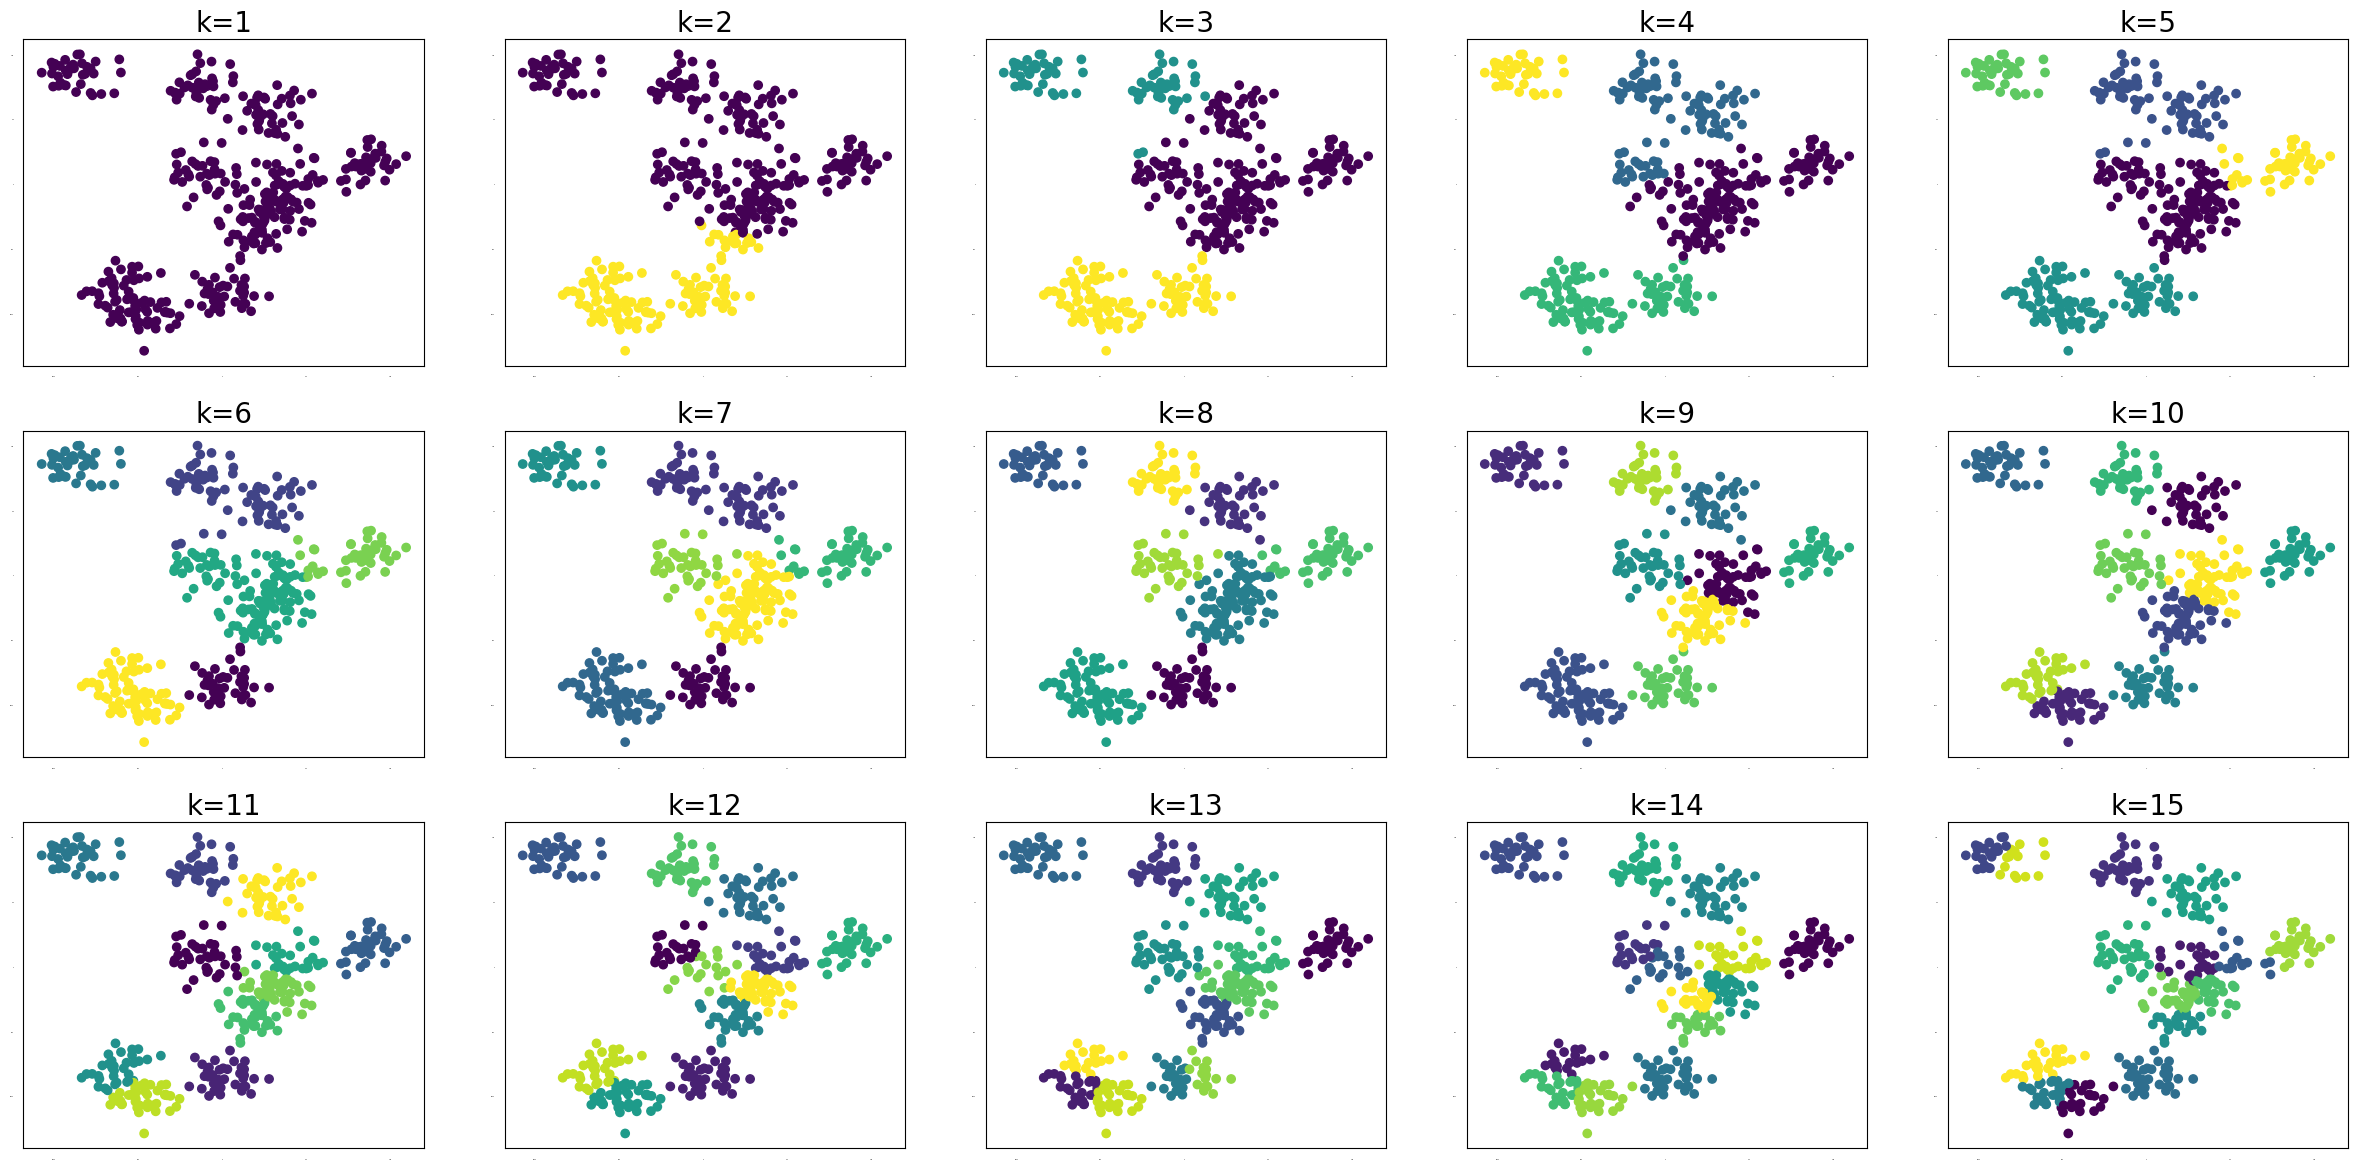

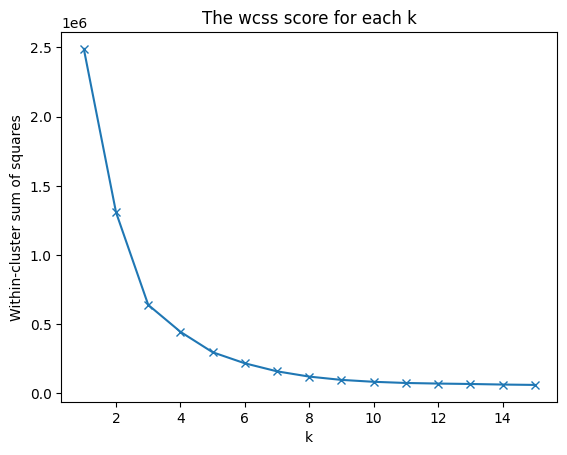

In [143]:
scores = []
# Display clustering for each analysed K
initPlotGrid(5, 15)
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(data)
    scores.append(kmeans.score(data) * -1)
    addToGrid()
    plt.title("k="+str(k), fontsize=20)
    plt.scatter(data[0], data[1], c=kmeans.predict(data))
finalizePlotGrid()

# Display the elbow method
x_ticks = list(range(1, len(scores) + 1))
plt.plot(x_ticks, scores, 'x-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The wcss score for each k')
plt.show()

Używając metody łokcia można wnioskować że optymalną liczbą klastrów będzie cztery. Różni się to od naszego pierwtonej tezy "na oko" dosyć znacząco, jednak wykresu podziału na klastry uzasadniają taki wybór.

## Klasteryzacja hierarchiczna + silhouette

In [140]:
def silhouettePlot(X, y_pred, k):
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    
    plt.axvline(x=silhouette_score(X, y_pred), color="red", linestyle="--")
    
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.title("$k={}$".format(k), fontsize=20)

*Źródło: https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb*

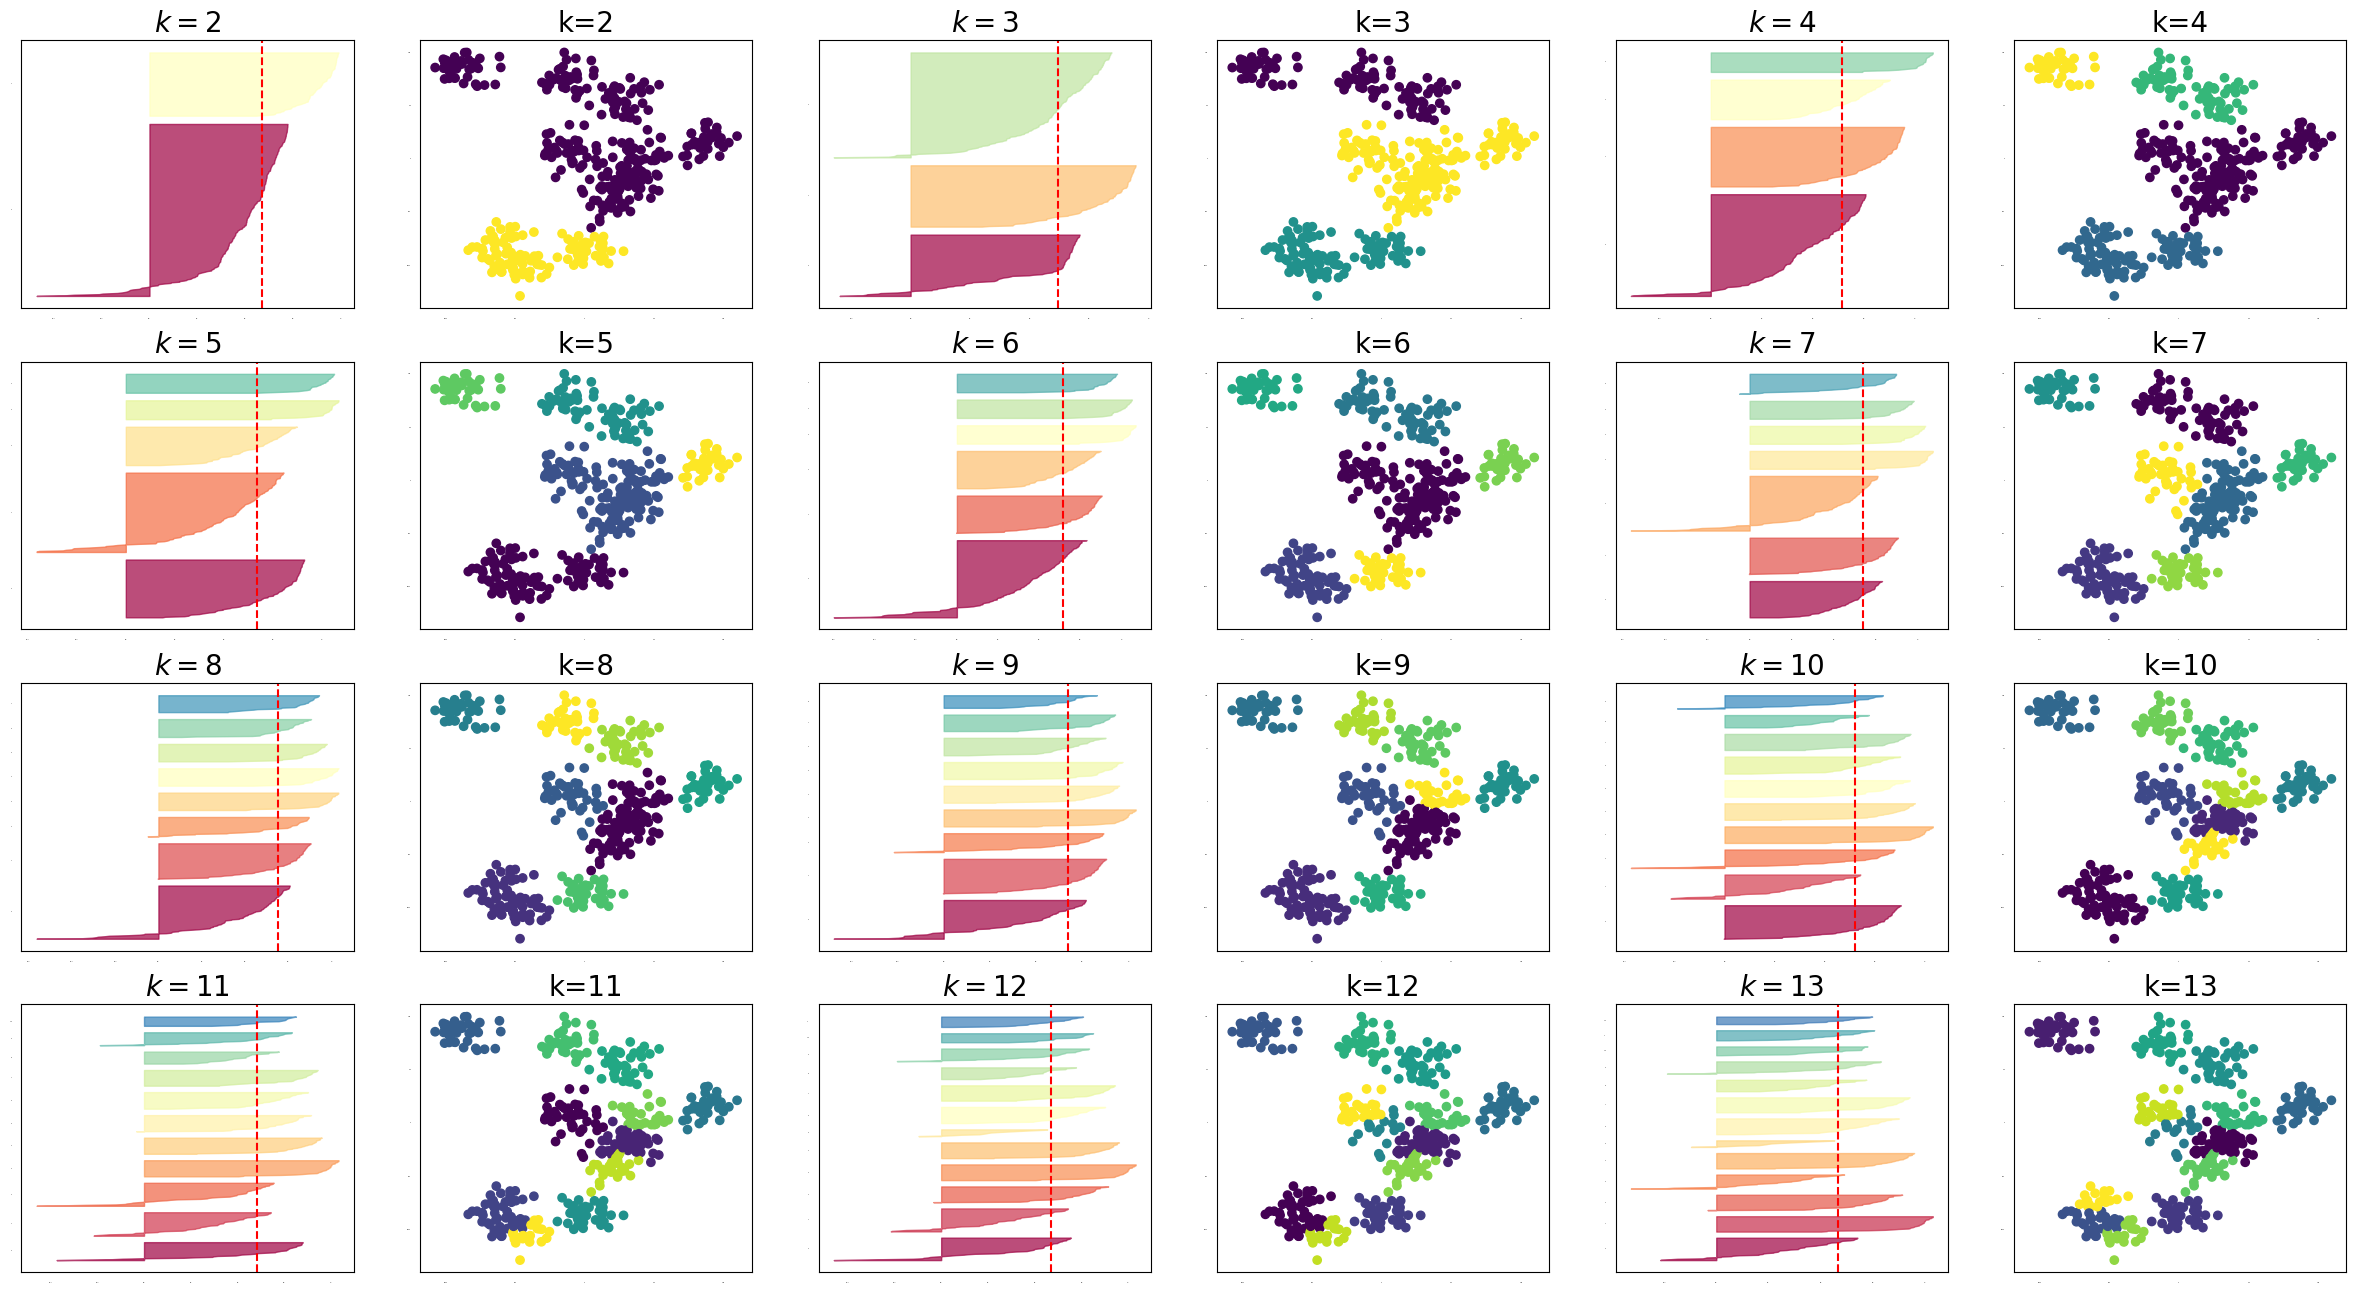

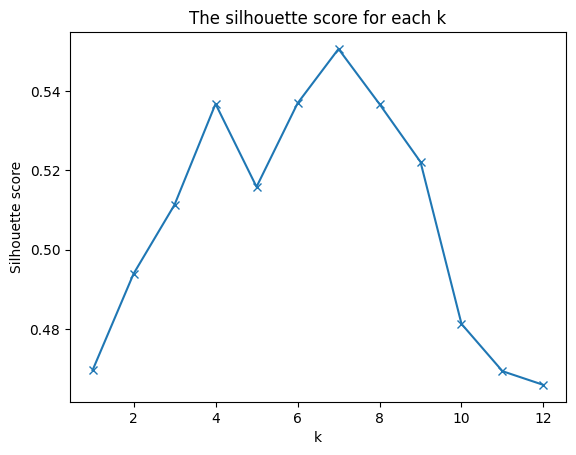

In [149]:
scores = []
# Display clustering for each analysed K
initPlotGrid(6, 24)
for k in range(2, 14):
    model = AgglomerativeClustering(n_clusters=k)
    y_pred = model.fit_predict(data)
    scores.append(silhouette_score(data, y_pred))
    addToGrid()
    silhouettePlot(data, y_pred, k)
    addToGrid()
    plt.title("k="+str(k), fontsize=20)
    plt.scatter(data[0], data[1], c=y_pred)
finalizePlotGrid()

# Display the silhouette scores
x_ticks = list(range(1, len(scores) + 1))
plt.plot(x_ticks, scores, 'x-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('The silhouette score for each k')
plt.show()

Znowu widzimy że 4 wydaje się być odpowiednią ilością klastrów. Jednak ta metoda potwierdza także nasze wcześniejsze podejrzenia co do proponowanej ilości klastrów - według niej najlepszą liczbą klastrów jest 7, co jest blisko wartości którą "zgadywaliśmy". Wykres sylwetek także potwierdza że będzie to dobra wartość - wszystkie klastry "sięgają" przerywanej linii, a ich wielkości są bardziej zrównoważone niż w przypadku 4 klastrów. Warto także zwrócić uwagę na odstający ogon - są to punkty które zostały prawdpodobnie błednie zaklasyfikowane. Chcielibyśmy aby takiego ogona w ogóle nie było, jednak występuje on w każdej rozpatrywanej ilości klastrów.

## Podsumowanie

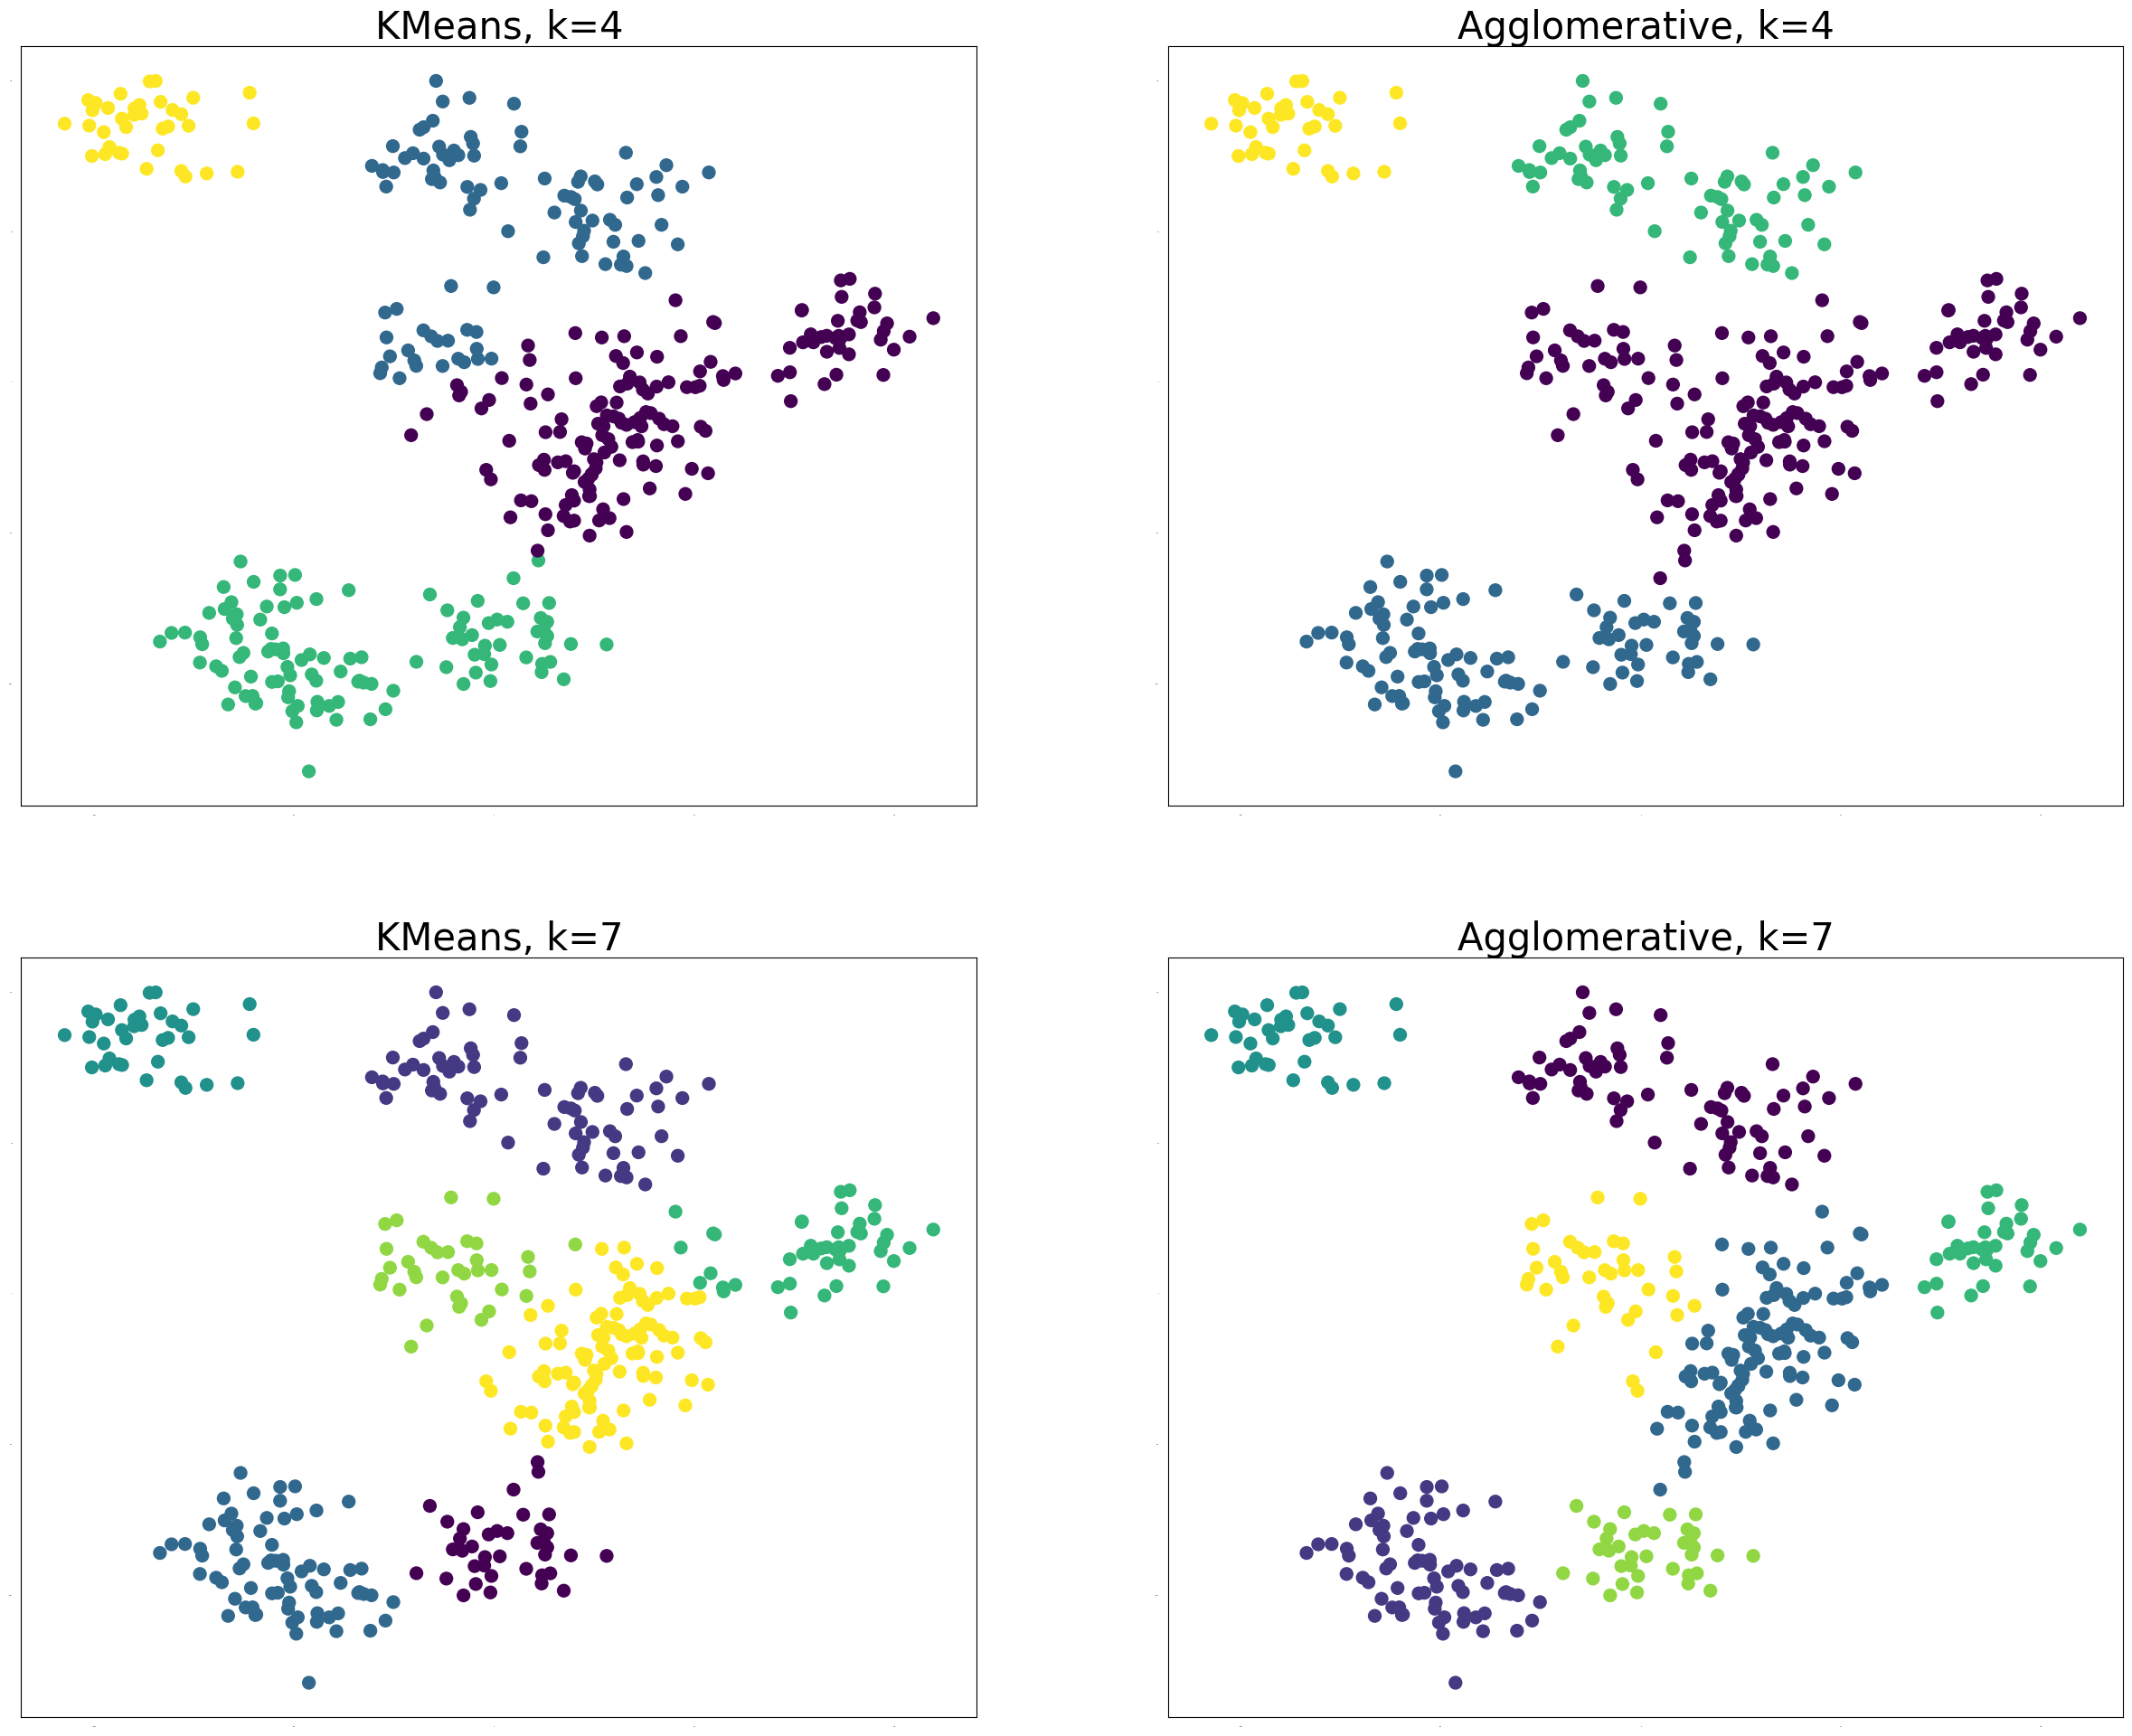

In [157]:
initPlotGrid(2, 4)
for k in [4, 7]:
    addToGrid()
    kmeans = KMeans(n_clusters=k, random_state=7)
    plt.title("KMeans, k="+str(k), fontsize=30)
    plt.scatter(data[0], data[1], c=kmeans.fit_predict(data), s=100)
    addToGrid()
    aggl = AgglomerativeClustering(n_clusters=k)
    plt.title("Agglomerative, k="+str(k), fontsize=30)
    plt.scatter(data[0], data[1], c=aggl.fit_predict(data), s=100)
finalizePlotGrid()

W tym wypadku najlepszą liczbą klastrów jest 7. W zależności od dalszego wykorzystania klastrów 4 też może być dobrą wartością.

Warto także zauważyć, że utworzone klastry różnią się w zależności od metody. Jest to szczególnie widoczne jeśli tych klastrów jest tylko 4. W porównaniu, wykorzystanie metody aglomeracji hierarchiczne daje rezultaty wyglądające bardziej organicznie. Zatem właśnie tej metody należałoby użyć.